# Gated Recurrent Unit (GRU) - Deep Learning Day 31

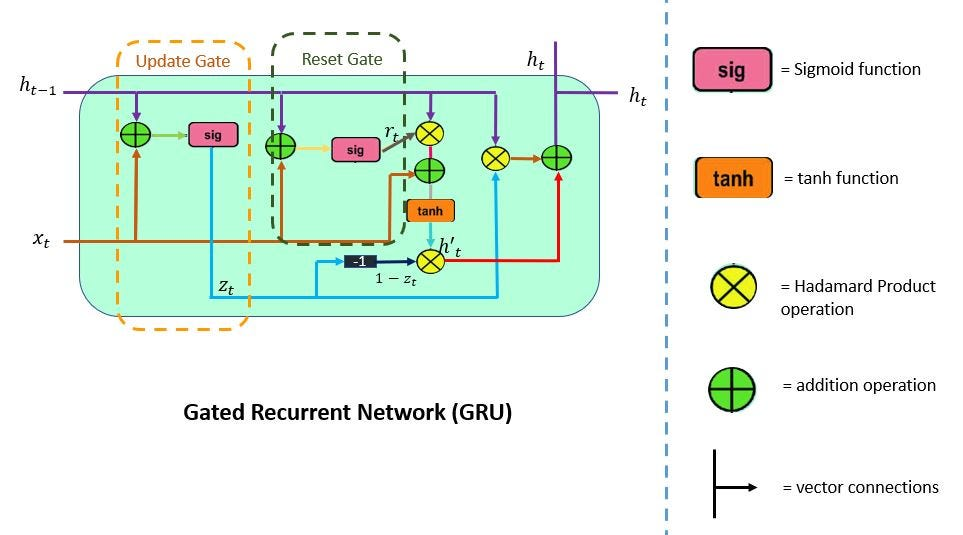

In [20]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

- GRU better ?? 
Yes ,
- GRU doesn’t contain a cell state
- GRU uses its hidden states to transport information
- It Contains only 2 gates(Reset and Update Gate)
- GRU is faster than LSTM
- GRU has lesser tensor’s operation that makes it faster

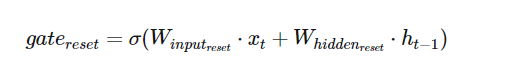

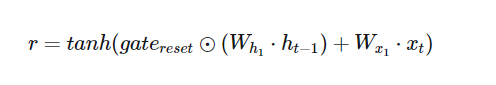

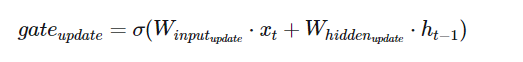

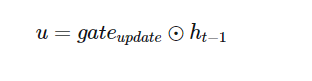

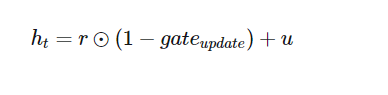

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [22]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [23]:
df1=pd.read_csv(r'data_for_gru\AEP_hourly.csv')

In [24]:
df2=(r'data_for_gru\COMED_hourly.csv')
df3=(r'data_for_gru\DAYTON_hourly.csv')
df4=(r'data_for_gru\DOM_hourly.csv')
df5=(r'data_for_gru\DUQ_hourly.csv')
df6=(r'data_for_gru\EKPC_hourly.csv')
df7=(r'data_for_gru\FE_hourly.csv')
df8=(r'data_for_gru\NI_hourly.csv')
df9=(r'data_for_gru\PJM_Load_hourly.csv')
df10=(r'data_for_gru\PJME_hourly.csv')
df11=(r'data_for_gru\PJMW_hourly.csv')

In [25]:
data_dir = [df2,df3,df4,df5,df6,df7,df8,df9,df10,df11]

In [26]:
df1.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [27]:
label_scalars = {}
train_x = []
test_x = {}
test_y = {}

for file in tqdm(data_dir):
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(file)  # Use 'file' directly, assuming 'file' contains the file path
    # Processing the time data into suitable input formats
    df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert 'Datetime' column to datetime format
    df['hour'] = df['Datetime'].dt.hour  # Extract hour
    df['dayofweek'] = df['Datetime'].dt.dayofweek  # Extract day of the week
    df['month'] = df['Datetime'].dt.month  # Extract month
    df['dayofyear'] = df['Datetime'].dt.dayofyear  # Extract day of the year
    df = df.sort_values("Datetime").drop("Datetime", axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalars[file] = label_sc
    
    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [29]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

- GRU

In [30]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

- LSTM

In [31]:
class LSTMNet(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,n_layers,drop_prob=0.2):
        super(LSTMNet,self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim,hidden_dim,n_layers,batch_first=True,dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim,output_dim)
        self.relu = nn.ReLU()
    
    def forward(self,x,h):
        out, h = self.lstm(x,h)
        out = self.fc(self.relu(out[:,-1]))
        return out,h
    
    def init_hidden(self,batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers,batch_size,self.hidden_dim).zero().to(device),weight.new(self.n_layers,batch_size,self.hidden_dim).zero().to(device))
        return hidden

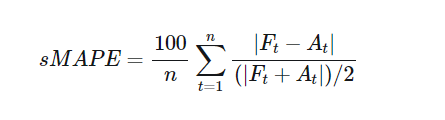

In [38]:
def train(train_loader, learn_rate, hidden_dim=10, EPOCHS=2, model_type="GRU"): #hidden_dim = 256 
        
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model))
    epoch_times = []
    # Start training loop

    for epoch in range(1, EPOCHS+1):
        start_time = time.perf_counter()  # Updated here
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter % 200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.perf_counter()  # Updated here
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time - start_time)))
        epoch_times.append(current_time - start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.perf_counter()  # Use time.perf_counter() to measure time
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {:.2f} seconds".format(time.perf_counter() - start_time))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {:.2f}%".format(sMAPE*100))
    return outputs, targets, sMAPE


In [36]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU") 

Starting Training of GRUNet(
  (gru): GRU(5, 10, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
) model
Epoch 1......Step: 200/800....... Average Loss for Epoch: 0.013114647752372548
Epoch 1......Step: 400/800....... Average Loss for Epoch: 0.007940071511548012
Epoch 1......Step: 600/800....... Average Loss for Epoch: 0.0059888827172107995
Epoch 1......Step: 800/800....... Average Loss for Epoch: 0.0048868915303319225
Epoch 1/2 Done, Total Loss: 0.0048868915303319225
Total Time Elapsed: 128.4990625999999 seconds
Epoch 2......Step: 200/800....... Average Loss for Epoch: 0.0012288303358945997
Epoch 2......Step: 400/800....... Average Loss for Epoch: 0.0011076171138847712
Epoch 2......Step: 600/800....... Average Loss for Epoch: 0.0010219413183707123
Epoch 2......Step: 800/800....... Average Loss for Epoch: 0.0009562145213567419
Epoch 2/2 Done, Total Loss: 0.0009562145213567419
Total Time Elapsed: 128.88227180000104 

In [39]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalars)

Evaluation Time: 3.45 seconds
sMAPE: 0.60%


In [ ]:
#lstm_outputs, targets, lstm_sMAPE = evaluate(Lstm_model, test_x, test_y, label_scalars)

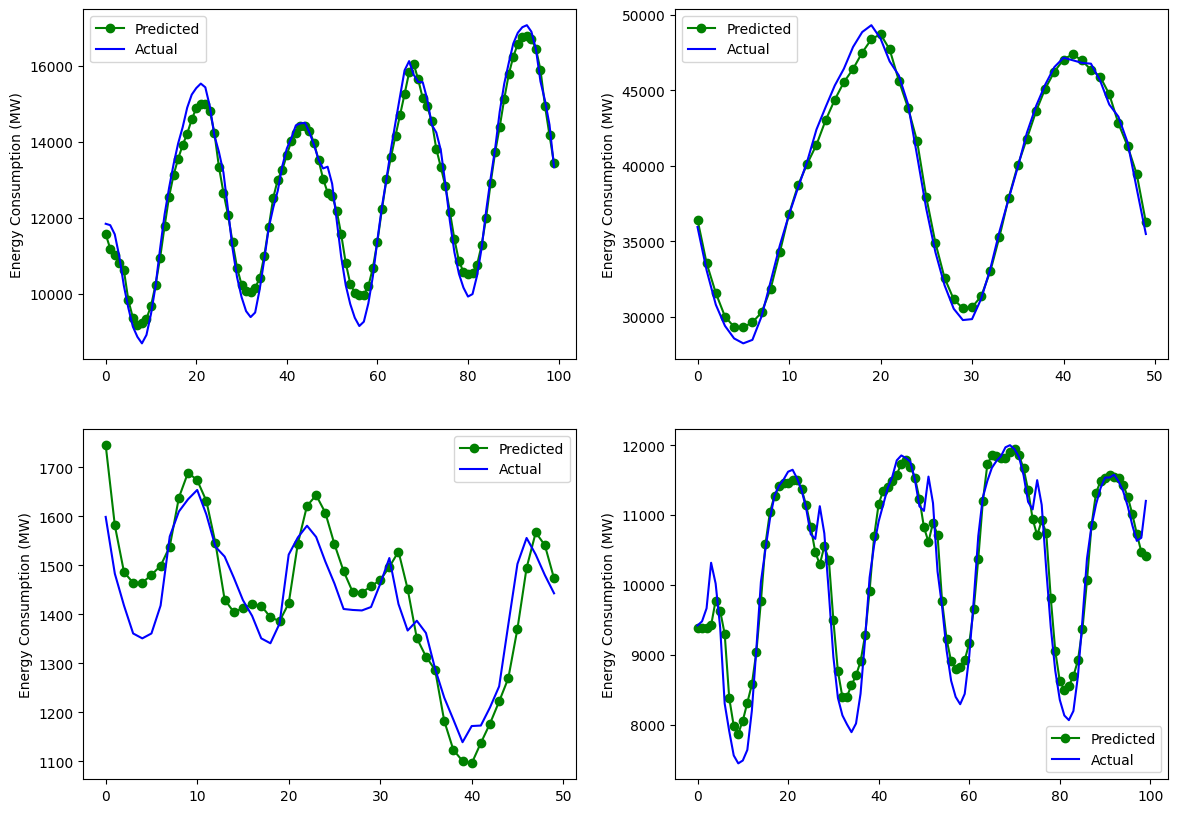

In [41]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,2)
plt.plot(gru_outputs[8][-50:], "-o", color="g", label="Predicted")
plt.plot(targets[8][-50:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[4][:50], "-o", color="g", label="Predicted")
plt.plot(targets[4][:50], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,4)
plt.plot(gru_outputs[6][:100], "-o", color="g", label="Predicted")
plt.plot(targets[6][:100], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()